<a href="https://colab.research.google.com/github/dbtronics/Twitter-Sentiment-Analysis-on-Johnny-Amber-Case/blob/main/Johnny_Depp_vs_Amber_Heard_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
!pip install snscrape
!pip install transformers
import snscrape.modules.twitter as sntwitter
from transformers import pipeline
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.5 MB/s 
     |████████████████████████████████| 6.6 MB 29.2 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")
# sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

# Extracting Tweets

* Extracts tweets using the search term and from start to end date
* Returns in pandas dataframe

In [ ]:
def tweets(n_tweets, search_term, start_date, end_date):
  """
  get a dataframe of tweets by search term
    
  ref: https://betterprogramming.pub/how-to-scrape-tweets-with-snscrape-90124ed006af
  """
  # Creating list to append tweet data to
  tweets_list2 = []

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{search_term} since:{start_date} until:{end_date}').get_items()):
    if i>n_tweets:
      break
    tweets_list2.append([tweet.date, tweet.id, tweet.content])

  # Creating a dataframe from the tweets list above
  tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text'])
  return tweets_df2

In [ ]:
# name = ['johnny depp', 'amber heard']
# # name =
# start_date = '2020-12-01'
# end_date = '2021-03-01'
# n_tweets = 10000-1

# print("Johnny Depp Data")
# johnny_data = tweets(n_tweets, name[0], start_date, end_date)
# johnny_data.head(100)

# # print("Amber Heard Data")
# # amber_data = tweets(n_tweets, name[1], start_date, end_date)
# # amber_data.head(10)

# Preprocess Data

* Remove URLs
* Small letters
* Remove tweets with multiple names mentioned
* Only include tweets with hashtags

In [ ]:
def preprocess(df_dict, remove_rows, keep_rows):
  for key, df in df_dict.items():
    print(key.title())
    initial_count = len(df_dict[key])
    df_dict[key] = (
      df
      # Make everything lower case
      # .assign(Text=lambda x: x['Text'].str.lower())
      .assign(
          Text = lambda x: x['Text'].str.lower(),
          keep_flag = lambda x: x['Text'].str.contains(keep_rows[key]),
          drop_flag = lambda x: x['Text'].str.contains(remove_rows[key])
      )
      # Remove the rows that mentioned the other three people.
      .query("drop_flag == False")
      # .query(f'~Text.str.contains("{remove_rows[key]}")')
      # Keep the rows that mention name 
      # .query(f'Text.str.contains("{keep_rows[key]}")')
      .query("keep_flag == True")
      # Remove all the URLs
      # .assign(Text=lambda x:x['Text'].apply(lambda s: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', s)))
      .assign(
        Text = lambda x: x['Text'].str.replace(
            r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
            '', 
            regex=True)
        )
      .assign(
          hashtags_flag = lambda x: x['Text'].str.contains("#")
      )
      .query("hashtags_flag == True")
      .drop(["keep_flag", "drop_flag", "hashtags_flag"], axis = "columns")
    )
    
    final_count = len(df_dict[key])
    print("%d tweets kept out of %d --> %.2f percent retention" % (final_count, initial_count, final_count/initial_count*100.0))

  return df_dict

# Main Code

## Save/Load Large Chunk of Data
This is only executed if condition is true

In [ ]:
save_data = True
read_data = True

name = ['johnny depp', 'amber heard']
# name=['amber heard']
# name = 'johnny depp'
# name = 'amber heard'
# start_date = ['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', 
                # '2022-01,01', '2022-02,01', '2022-03,01', '2022-04,01', '2022-05,01'] # June '21 - May '22
# start_date = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01'] # Jan '21 - May '21
# start_date = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', 
              # '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01'] # Jan '21 - Nov '21
start_date = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'] # Jan '22 - June '22
# end_date = ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'] # Feb '21 - June '21
# end_date = ['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', 
                # '2022-01,01', '2022-02,01', '2022-03,01', '2022-04,01', '2022-05,01', '2022-06-01'] # July '21 - June '22
# end_date = ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', 
              # '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'] # Feb '21 - Dec '21
end_date = ['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-06-20'] # Feb '22 - 20 June '22
n_tweets = 8e4 # extract 80k tweets from the timeline

# if (save_data):
#   for i in range(len(start_date)):
#     data = tweets(n_tweets, name, start_date[i], end_date[i])
#     file_name = 'data_johnny_'+str(i)
#     # file_name = 'data_amber_'+str(i)
#     data.to_pickle(file_name)
#     print("Date period: %s to %s COMPLETED"%(start_date[i], end_date[i]))

if (save_data):
  for name_index in range(len(name)):
    print("Saving data for %s"%name[name_index].title())
    for i in range(len(start_date)):
      data = tweets(n_tweets, name[name_index], start_date[i], end_date[i])
      # file_name = 'data_johnny_'+str(i)
      # file_name = 'data_amber_'+str(i)
      file_name = "data_"+name[name_index].replace(" ", "")+"_"+str(i)
      data.to_pickle(file_name)
      print("Date period: %s to %s COMPLETED"%(start_date[i], end_date[i]))
    print("")


if (read_data):
  for name_index in range(len(name)):
    print("Reading Data for %s\n"%name[name_index].title())
    for i in range(len(start_date)):
      # file_name = 'data_johnny_'+str(i)
      # file_name = 'data_amber_'+str(i)
      file_name = "data_"+name[name_index].replace(" ", "")+"_"+str(i)
      read_data = pd.read_pickle(file_name)
      print("Date range: %s to %s with total data of %s"%(start_date[i], end_date[i], read_data.shape[0]))
      print(read_data.head())
      # print(read_data.shape[0])
      print("\n\n_________________________________________________________________\n\n")
      # print(type(read_data))

Reading Data for Johnny Depp

Date range: 2022-01-01 to 2022-02-01 with total data of 44167
                   Datetime             Tweet Id  \
0 2022-01-31 23:59:52+00:00  1488301032329330693   
1 2022-01-31 23:57:51+00:00  1488300527632932865   
2 2022-01-31 23:56:07+00:00  1488300092075479040   
3 2022-01-31 23:55:47+00:00  1488300005467250688   
4 2022-01-31 23:55:18+00:00  1488299886558814209   

                                                Text  
0  since january is over, tell us which johnny de...  
1  Tonight’s movie of choice. 📸🎞🏭\n\n#Minamata #M...  
2  pensando nele 😍😍😍 no johnny depp de cropped em...  
3  Big shoutout to the community in @JohnnyDeppNF...  
4  @Marlene15732419 @UniversoDepp @RosePagaza @55...  


_________________________________________________________________


Date range: 2022-02-01 to 2022-03-01 with total data of 65188
                   Datetime             Tweet Id  \
0 2022-02-28 23:59:57+00:00  1498447914456305664   
1 2022-02-28 23:59:37+00:00  

Combine all the saved data into a single Dataframe

In [ ]:
johnny_array = []
amber_array = []

for i in range(len(start_date)):
  # johnny_file = "data_johnny_"+str(i)
  # amber_file = "data_amber_"+str(i)
  johnny_file = "data_"+name[0].replace(" ", "")+"_"+str(i)
  amber_file = "data_"+name[1].replace(" ", "")+"_"+str(i)
  johnny_array.append(pd.read_pickle(johnny_file))
  amber_array.append(pd.read_pickle(amber_file))

johnny_data = pd.concat(johnny_array)
amber_data = pd.concat(amber_array)

print("Johnny Data: %d"%johnny_data.shape[0])
print("Amber Data: %d"%amber_data.shape[0])
# print(johnny_data.shape)
# print(amber_data.shape)

Johnny Data: 389451
Amber Data: 277406


In [ ]:
df_dict = {
    'johnny depp': johnny_data,
    "amber heard": amber_data
}

remove_rows = {
    'johnny depp': 'amber|heard|camila|vasquez|shannon|curry',
    "amber heard": 'johnny|depp|camila|vasquez|shannon|curry'
}

keep_rows = {
    'johnny depp': 'johnny|depp',
    "amber heard": 'amber|heard'
}

df_test_data = preprocess(df_dict, remove_rows, keep_rows)

print("\n\nShuffle the data and extract first 5,000 tweets from year 2022\n\n")
# Shuffle the data so that you get random tweet from Jan '22 to June '22
# and import only 5000 records only due to limited resources
for key, df in df_dict.items():
  df = shuffle(df)
  df.reset_index(inplace=True, drop=True) # reset index after shuffle
  df = df.loc[:5000-1, :]
  df_dict[key] = df
  print("%s Data: %d"%(key.title(), df_dict[key].shape[0]))
  print(df_dict[key].head())
  print("----------------------------------\n")

print("\n\nCOMPLETED!")

Johnny Depp
82019 tweets kept out of 389451 --> 21.06 percent retention
Amber Heard
28076 tweets kept out of 277406 --> 10.12 percent retention


Shuffle the data and extract first 1,000 tweets from year 2022


Johnny Depp Data: 5000
                   Datetime             Tweet Id  \
0 2022-03-03 20:12:03+00:00  1499477724318081027   
1 2022-01-15 14:40:09+00:00  1482361971236347907   
2 2022-03-30 20:24:43+00:00  1509265384939167747   
3 2022-04-30 10:43:53+00:00  1520353240465903616   
4 2022-03-04 00:40:56+00:00  1499545391926333447   

                                                Text  
0  @theacademy 12/\n#minimata\n#johnnydepp\n#osca...  
1  +\nah claims #johnnydepp was jealous at her ex...  
2  "i went to this store, stuffed it down my pant...  
3  start watching #johnnydepp  movies  starting w...  
4  i vote for\n#minamata \n#oscarsfanfavorite \n#...  
----------------------------------

Amber Heard Data: 5000
                   Datetime             Tweet Id  \
0 2022-06-15

In [ ]:
johnny_sentiment = [None]*len(df_dict['johnny depp'])
amber_sentiment = [None]*len(df_dict['amber heard'])
sentiment_dict = {
    'johnny depp': johnny_sentiment,
    'amber heard': amber_sentiment
    }

for key, df in df_dict.items():
  print(key.title())
  df_dict[key] = df_dict[key].assign(Sentiment = lambda x: x['Text'].apply(lambda s: sentiment_pipeline(s)))
  sentiment_dict[key] = df_dict[key].loc[:, 'Sentiment']

# Dictionary is stored inside a list so this procedure removes the list
for key, _ in df_dict.items():
  for i in range(len(sentiment_dict[key])):
    sentiment_dict[key][i] = sentiment_dict[key][i][0]
    sentiment_dict[key][i] = sentiment_dict[key][i]['label'] # extract only labels from the list and discard score


print("\n\nSentiment Analysis Done!")


Johnny Depp
Amber Heard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Sentiment Analysis Done!


## Visual Representation of Sentiment Analysis

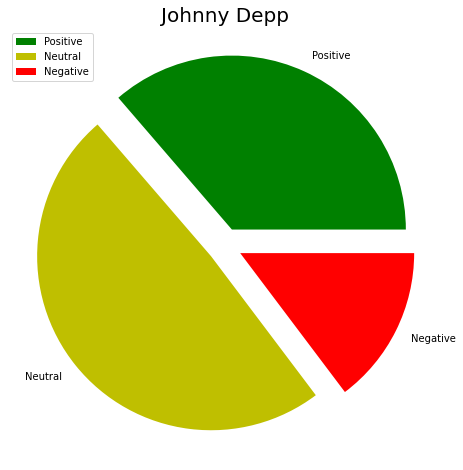

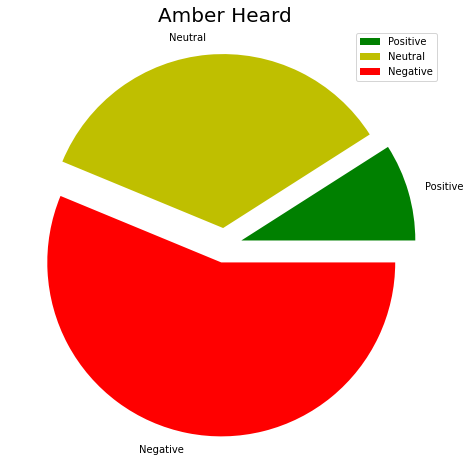

In [ ]:
sentiment_label = ['Positive', 'Neutral', 'Negative']

johnny_sentiment_count = [None]*3
amber_sentiment_count = [None]*3
sentiment_count_dict = {
    'johnny depp': johnny_sentiment_count,
    'amber heard': amber_sentiment_count
}

# get sentiment count for both
for key, _ in sentiment_count_dict.items():
  for i in range(len(sentiment_label)):
    sentiment_count_dict[key][i] = np.sum(sentiment_dict[key]==sentiment_label[i])
  # print(sentiment_count_dict[key])

# convert to percentage
for key, _ in sentiment_count_dict.items():
  total_data = np.sum(sentiment_count_dict[key])
  for i in range(len(sentiment_label)):
    sentiment_count_dict[key][i] = sentiment_count_dict[key][i] / total_data * 100
  # print(sentiment_count_dict[key])
  
for key, _ in df_dict.items():
  plt.figure(figsize=(8, 8))
  name = "Johnny Depp" if key=="johnny depp" else "Amber Heard"
  plt.pie(sentiment_count_dict[key], labels = sentiment_label, colors=["g", "y", "r"], explode=[0.1, 0.1, 0.1])
  plt.legend(loc="best")
  plt.title(name, fontdict={'fontsize': 20})
  # plt.
  plt.show()
  print("")

## Top 5 Hashtags Used 

In [ ]:
def hashtag_extract(data):
  N = data.shape[0]
  # print(data)
  list_hashtag = []
  for i in range(N):
    # print(type(data[i]))
    text = data[i]

    for word in text.split():
      if word[0]=="#":
        list_hashtag.append(word[1:])
  
  return list_hashtag


In [ ]:
johnny_tweets = df_dict['johnny depp'].loc[:, 'Text']
amber_tweets = df_dict['amber heard'].loc[:, 'Text']

johnny_positive_tweets = johnny_tweets[sentiment_dict['johnny depp']=="Positive"]
johnny_positive_tweets.reset_index(inplace=True, drop=True)
johnny_negative_tweets = johnny_tweets[sentiment_dict['johnny depp']=="Negative"]
johnny_negative_tweets.reset_index(inplace=True, drop=True)

amber_positive_tweets = amber_tweets[sentiment_dict['amber heard']=="Positive"]
amber_positive_tweets.reset_index(inplace=True, drop=True)
amber_negative_tweets = amber_tweets[sentiment_dict['amber heard']=="Negative"]
amber_negative_tweets.reset_index(inplace=True, drop=True)

# print(type(johnny_positive_tweets))
johnny_positive_hashtag = hashtag_extract(johnny_positive_tweets)
johnny_positive_hashtag_unique = np.unique(johnny_positive_hashtag)
johnny_negative_hashtag = hashtag_extract(johnny_negative_tweets)
johnny_negative_hashtag_unique = np.unique(johnny_negative_hashtag)

amber_positive_hashtag = hashtag_extract(amber_positive_tweets)
amber_positive_hashtag_unique = np.unique(amber_positive_hashtag)
amber_negative_hashtag = hashtag_extract(amber_negative_tweets)
amber_negative_hashtag_unique = np.unique(amber_negative_hashtag)

# johnny_positive_hashtag_unique_freq = [None]*len(johnny_positive_hashtag_unique)
johnny_positive_hashtag_unique_freq = []
for hashtag in johnny_positive_hashtag_unique:
#   johnny_positive_hashtag_unique_freq.append(np.sum(johnny_positive_hashtag==hashtag))
  count=0
  for hashtag_compare in johnny_positive_hashtag:
    count = (count+1) if hashtag==hashtag_compare else count
  johnny_positive_hashtag_unique_freq.append(count)

johnny_negative_hashtag_unique_freq = []
for hashtag in johnny_negative_hashtag_unique:
#   johnny_negative_hashtag_unique_freq.append(np.sum(johnny_negative_hashtag==hashtag))
  count=0
  for hashtag_compare in johnny_negative_hashtag:
    count = (count+1) if hashtag==hashtag_compare else count
  johnny_negative_hashtag_unique_freq.append(count)

amber_positive_hashtag_unique_freq = []
for hashtag in amber_positive_hashtag_unique:
  # amber_positive_hashtag_unique_freq.append(np.sum(amber_positive_hashtag==hashtag))
  count=0
  for hashtag_compare in amber_positive_hashtag:
    count = (count+1) if hashtag==hashtag_compare else count
  amber_positive_hashtag_unique_freq.append(count)

amber_negative_hashtag_unique_freq = []
for hashtag in amber_negative_hashtag_unique:
#   amber_negative_hashtag_unique_freq.append(np.sum(amber_negative_hashtag==hashtag))
  count=0
  for hashtag_compare in amber_negative_hashtag:
    count = (count+1) if hashtag==hashtag_compare else count
  amber_negative_hashtag_unique_freq.append(count)

pd_johnny_positive_hashtag = pd.DataFrame({"Hashtag": johnny_positive_hashtag_unique, 
                                           "Frequency": johnny_positive_hashtag_unique_freq})
pd_johnny_negative_hashtag = pd.DataFrame({"Hashtag": johnny_negative_hashtag_unique, 
                                           "Frequency": johnny_negative_hashtag_unique_freq})
pd_amber_positive_hashtag = pd.DataFrame({"Hashtag": amber_positive_hashtag_unique, 
                                           "Frequency": amber_positive_hashtag_unique_freq})
pd_amber_negative_hashtag = pd.DataFrame({"Hashtag": amber_negative_hashtag_unique, 
                                           "Frequency": amber_negative_hashtag_unique_freq})

pd_johnny_positive_hashtag = pd_johnny_positive_hashtag.sort_values(by=['Frequency'], ascending=False)
pd_johnny_positive_hashtag.reset_index(inplace=True, drop=True)

pd_johnny_negative_hashtag = pd_johnny_negative_hashtag.sort_values(by=['Frequency'], ascending=False)
pd_johnny_negative_hashtag.reset_index(inplace=True, drop=True)

pd_amber_positive_hashtag = pd_amber_positive_hashtag.sort_values(by=['Frequency'], ascending=False)
pd_amber_positive_hashtag.reset_index(inplace=True, drop=True)

pd_amber_negative_hashtag = pd_amber_negative_hashtag.sort_values(by=['Frequency'], ascending=False)
pd_amber_negative_hashtag.reset_index(inplace=True, drop=True)

In [ ]:
print("Johnny Depp Top 5 POSITIVE HASHTAGS")
pd_johnny_positive_hashtag.head(5)

Johnny Depp Top 5 POSITIVE HASHTAGS


,Hashtag,Frequency
0,johnnydepp,1358
1,minamata,384
2,oscarsfanfavorite,354
3,justiceforjohnnydepp,337
4,sweepstakes,319


In [ ]:
print("Johnny Depp Top 5 NEGATIVE HASHTAGS")
pd_johnny_negative_hashtag.head(5)

Johnny Depp Top 5 NEGATIVE HASHTAGS


,Hashtag,Frequency
0,johnnydepp,450
1,justiceforjohnnydepp,180
2,justiceforjohnnydeppvirginia2022,36
3,johnnydepp’s,35
4,mentoo,24


In [ ]:
print("Amber Heard Top 5 POSITIVE HASHTAGS")
pd_amber_positive_hashtag.head(5)

Amber Heard Top 5 POSITIVE HASHTAGS


,Hashtag,Frequency
0,amberheard,213
1,istandwithamberheard,99
2,justiceforamberheard,30
3,amberheardisaliar,25
4,amberheardisapsychopath,14


In [ ]:
print("Amber Heard Top 5 NEGATIVE HASHTAGS")
pd_amber_negative_hashtag.head(5)

Amber Heard Top 5 NEGATIVE HASHTAGS


,Hashtag,Frequency
0,amberheard,1328
1,amberheardisaliar,404
2,amberheardisanarcissist,219
3,amberheardisapsychopath,204
4,amberheardlsaliar,196
